In [1]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image

/mnt/disks/main/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

source_image = load_image('https://github.com/lllyasviel/ControlNet-v1-1-nightly/raw/main/test_imgs/dog64.png')
condition_image = resize_for_condition_image(source_image, 512)

/tmp/ipykernel_145974/884104601.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = input_image.resize((W, H), resample=Image.LANCZOS)


In [3]:
controlnet = ControlNetModel.from_pretrained('takuma104/control_v11', 
                                             subfolder='control_v11f1e_sd15_tile',
                                             torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    custom_pipeline="invertible_controlnet_img2img",
    controlnet=controlnet,
    torch_dtype=torch.float16).to('cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

/mnt/disks/main/.cache/huggingface/modules/diffusers_modules/local/pipeline.py:22: FutureWarning: Importing `StableDiffusionControlNetPipeline` or `MultiControlNetModel` from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet is deprecated. Please import `from diffusers import StableDiffusionControlNetPipeline` instead.
  from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet import (
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [4]:
import requests
from io import BytesIO
def my_load_image(url, size=None):
    response = requests.get(url,timeout=10)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

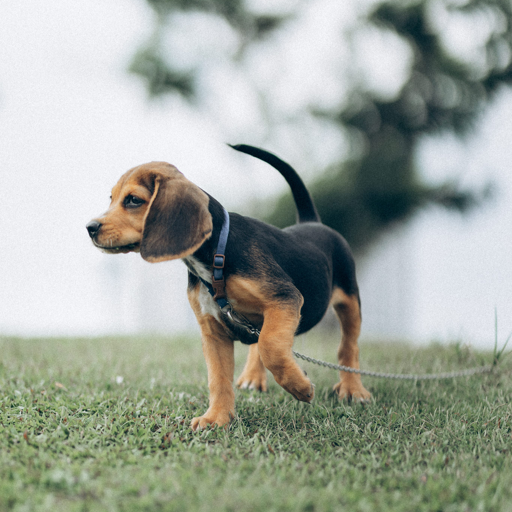

In [5]:
# https://www.pexels.com/photo/a-beagle-on-green-grass-field-8306128/
input_image = my_load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
input_image

In [43]:
from torchvision import transforms as tfms
device = 'cuda'
# encode with VAE
with torch.no_grad(): latent = pipe.vae.encode((tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1).half())
l = 0.18215 * latent.latent_dist.sample()

In [44]:
input_image_prompt = "Photograph of a puppy on the grass"
inverted_latents = pipe.invert(l, input_image_prompt,num_inference_steps=50)
inverted_latents.shape

  0%|          | 0/49 [00:00<?, ?it/s]

 98%|█████████▊| 48/49 [00:06<00:00,  6.98it/s]


torch.Size([48, 4, 64, 64])

In [117]:
# Decode the final inverted latents:
def visualize_latents(l):
    with torch.no_grad():
        im = pipe.decode_latents(l.unsqueeze(0))
    return pipe.numpy_to_pil(im)[0]

In [134]:
# source_image = load_image('https://github.com/lllyasviel/ControlNet-v1-1-nightly/raw/main/test_imgs/dog64.png')
# condition_image = resize_for_condition_image(source_image, 512)
source_image = load_image('./woman_dance/0001.png')
# source_image = my_load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
source_image = resize_for_condition_image(source_image, 712)
condition_image = load_image('./woman_dance/0005.png')
condition_image = resize_for_condition_image(condition_image, 712)

/tmp/ipykernel_145974/884104601.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = input_image.resize((W, H), resample=Image.LANCZOS)


In [135]:
def invert(image, prompt, negative_prompt, num_inference_steps):
    with torch.no_grad(): latent = pipe.vae.encode((tfms.functional.to_tensor(image).unsqueeze(0).to(device)*2-1).half())
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = pipe.invert(l, prompt=prompt, negative_prompt=negative_prompt,num_inference_steps=num_inference_steps)
    return inverted_latents

start_step = 10
num_inference_steps = 50
# prompt = "a photo of woman dancing, best quality"
prompt = "a photo of dog"
# negative_prompt = "bad anatomy, low quality"
negative_prompt = ""

In [136]:
inverted_latents = invert(source_image, prompt,negative_prompt=negative_prompt, num_inference_steps=num_inference_steps)
inverted_latents.shape

 98%|█████████▊| 48/49 [00:14<00:00,  3.23it/s]


torch.Size([48, 4, 88, 88])

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


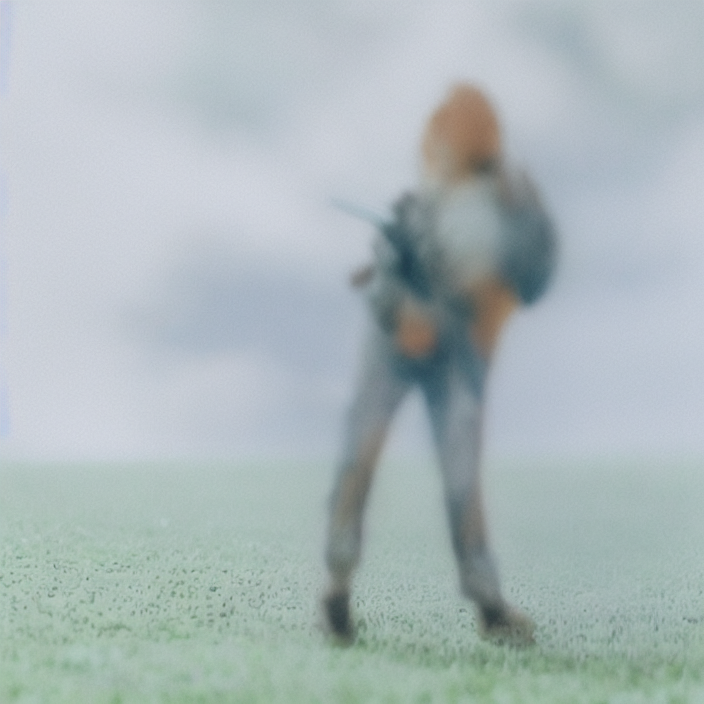

In [133]:
pipe(
    prompt=prompt, 
    # negative_prompt=negative_prompt,
    image=condition_image, 
    controlnet_conditioning_image=condition_image, 
    width=condition_image.size[0],
    height=condition_image.size[1],
    strength=1, 
    generator=torch.manual_seed(0),
    num_inference_steps=num_inference_steps, 
    guidance_scale=3, 
    controlnet_guidance_end=1,
    controlnet_conditioning_scale=1.0,
    latents=inverted_latents[-(start_step + 1)][None], 
    start_step=start_step
).images[0]

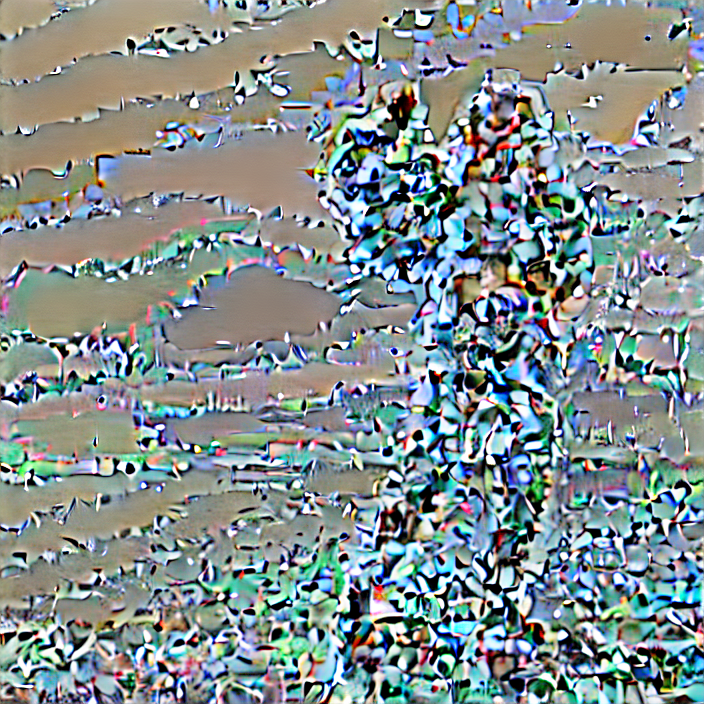

In [137]:
visualize_latents(inverted_latents[-10])

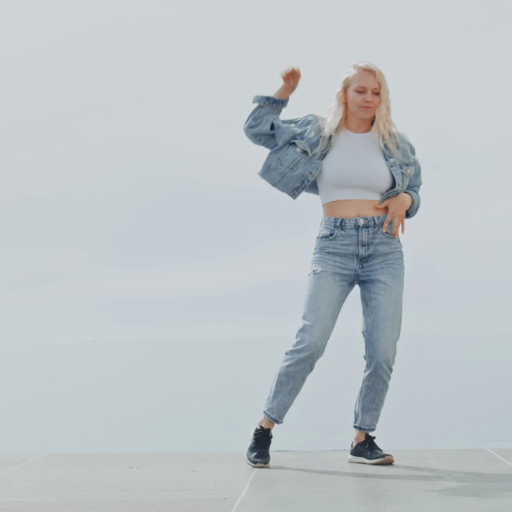

In [69]:
condition_image